# EMA cross EMA - Trap - Analytics

### Import Library

In [60]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [61]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [62]:
data = dataset.copy()

In [63]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [64]:
data["ema_fast"] = ta.ema(data["Close"], length=20)
data["ema_low"] = ta.ema(data["Close"], length=250)
data["ema_cross"] = ((data["ema_fast"] > data["ema_low"]) & (data["ema_fast"].shift(1) <= data["ema_low"].shift(1)) | (data["ema_fast"] < data["ema_low"]) & (data["ema_fast"].shift(1) >= data["ema_low"].shift(1)))

In [65]:
data[data.ema_cross == True]

,Open,High,Low,Close,Volume,ema_fast,ema_low,ema_cross
Date,,,,,,,,
2018-08-21 14:00:00,950.4,951.8,950.2,950.8,2849,948.814559,948.784204,True
2018-08-30 10:15:00,961.7,961.7,961.0,961.0,1027,962.030275,962.060930,True
2018-08-30 11:20:00,962.6,963.5,962.5,963.3,1514,962.040668,962.037060,True
2018-09-04 10:35:00,963.1,963.9,963.1,963.8,1356,964.749051,964.787876,True
2018-09-11 13:40:00,945.9,947.1,945.9,947.0,1645,944.820616,944.611729,True
...,...,...,...,...,...,...,...,...
2025-02-13 13:45:00,1337.2,1338.5,1336.5,1336.9,4460,1334.380176,1334.148219,True
2025-02-18 09:00:00,1335.3,1335.3,1332.8,1333.1,7051,1338.524221,1338.652775,True
2025-02-18 10:30:00,1344.9,1348.3,1344.9,1347.3,10368,1339.283340,1338.512776,True


### Preparing data for detecting TRAP

In [66]:
data['max_high_20bars_later'] = data['High'].shift(-20).rolling(20).max()
data['min_low_20bars_later'] = data['Low'].shift(-20).rolling(20).min()
data['hour'] = data.index.hour
data['year'] = data.index.year
data['month'] = data.index.month
data['year_month'] = data.index.strftime("%Y-%m")

In [67]:
data.dropna(inplace=True)

In [68]:
FORCE_SL = 4
def is_trap(r):
    trap = ''
    if r['ema_cross'] == True:
        if r['ema_fast'] > r['ema_low']:
            # Cross up - Long
            if r['min_low_20bars_later'] < r['Close'] - FORCE_SL:
                trap = 'yes'
            else:
                trap = 'no'
        else:
            # Cross down
            if r['max_high_20bars_later'] > r['Close'] + FORCE_SL:
                trap = 'yes'
            else:
                trap = 'no'
    return trap

In [69]:
data['trap'] = data.apply(lambda r: is_trap(r), axis=1)

In [70]:
len(data[data.trap == 'yes'])

194

In [71]:
len(data[data.trap == 'no'])

357

## Analytics by Time

<Axes: xlabel='hour'>

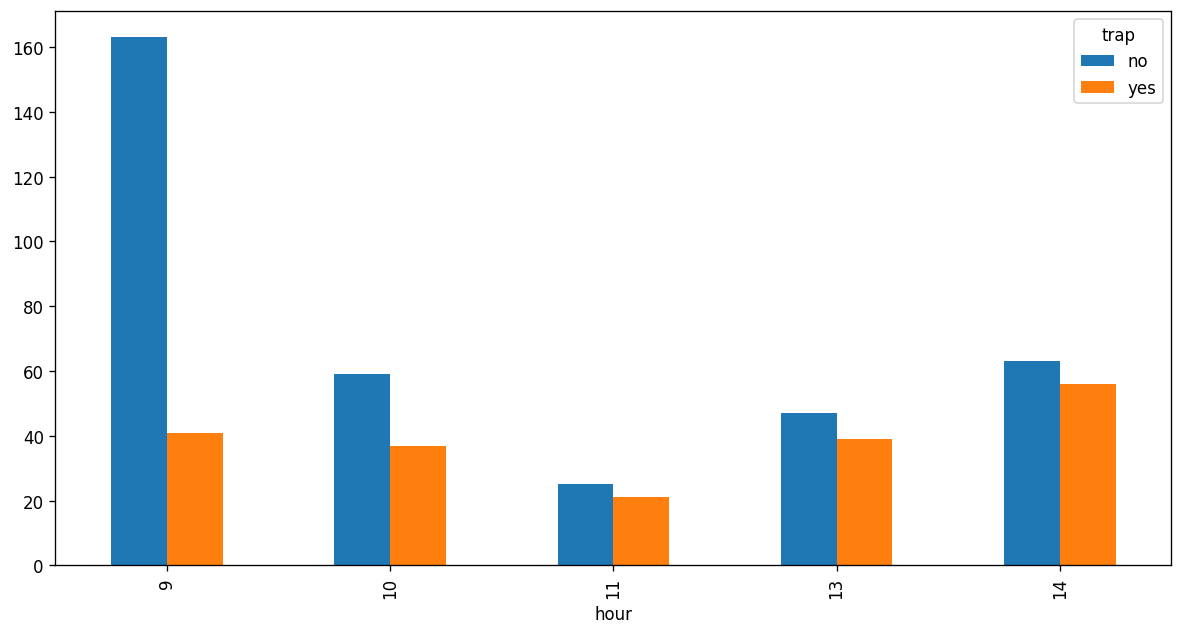

In [72]:
group_by_hour = data[data.trap != ''].groupby(['hour', 'trap'])['hour'].count().rename({'hour': 'count'})
group_by_hour.unstack().plot.bar()

<Axes: xlabel='year'>

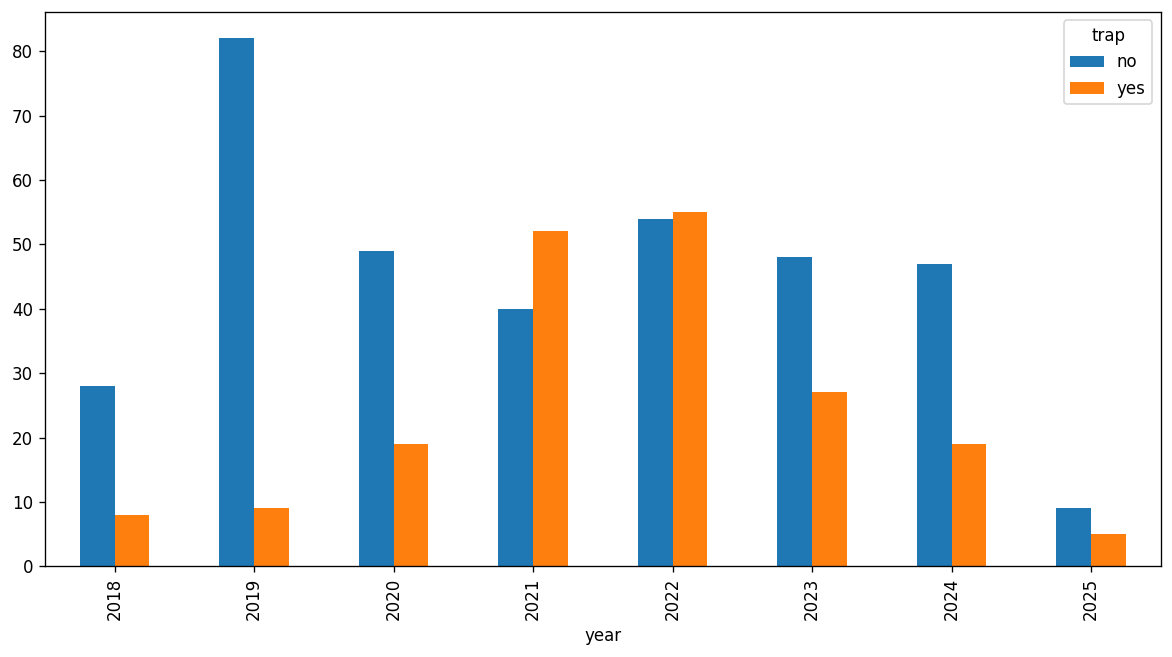

In [73]:
group_by_year = data[data.trap != ''].groupby(['year', 'trap'])['year'].count().rename({'year': 'count'})
group_by_year.unstack().plot.bar()

<Axes: xlabel='month'>

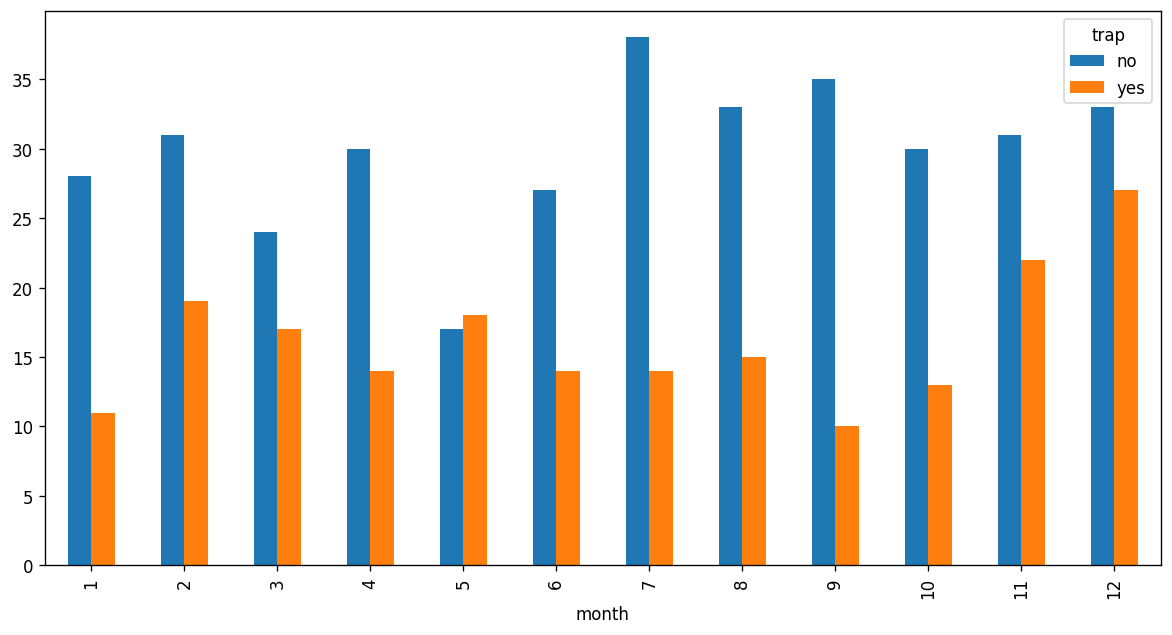

In [74]:
group_by_month = data[data.trap != ''].groupby(['month', 'trap'])['month'].count().rename({'month': 'count'})
group_by_month.unstack().plot.bar()

<Axes: xlabel='year_month'>

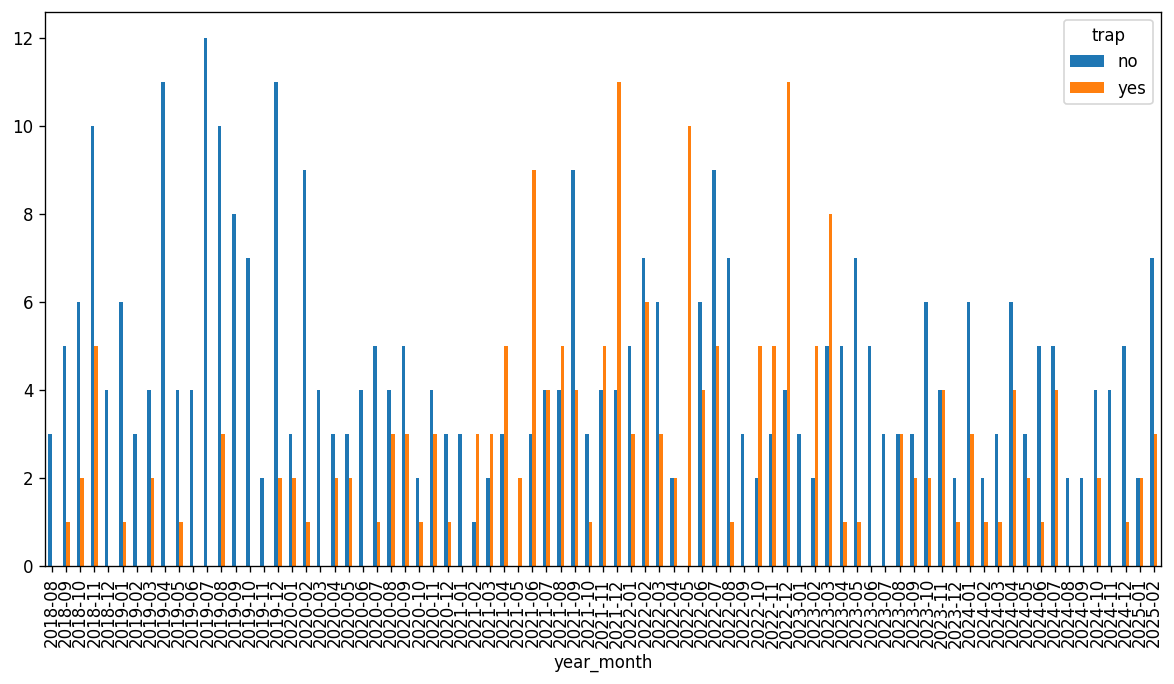

In [75]:
group_by_year_month = data[data.trap != ''].groupby(['year_month', 'trap'])['year_month'].count().rename({'year_month': 'count'})
group_by_year_month.unstack().plot.bar()

## Pull back analytics

### Cross up pull back

In [76]:
cross_up_data = data[(data.ema_cross==True) & (data.ema_fast > data.ema_low)]
cross_up_data["pull_back"] = cross_up_data["Close"] - cross_up_data["min_low_20bars_later"]

<Axes: title={'center': 'Cross up and pull back'}, xlabel='Date'>

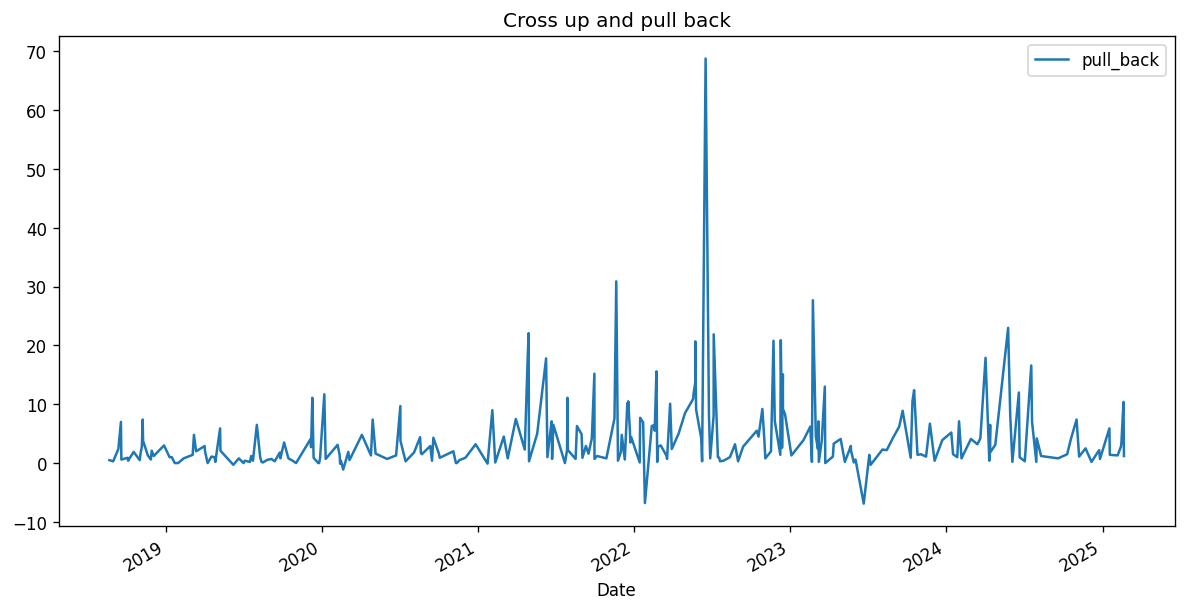

In [77]:
cross_up_data.plot(kind="line", y="pull_back",  title="Cross up and pull back")

In [78]:
trap_percent = 100 * round(len(cross_up_data[cross_up_data.trap == 'yes']) / len(cross_up_data), 3)
pie_data = {
    "Trap": ["Yes", "No"],
    "Percent": [trap_percent, 100 - trap_percent]
}

<Axes: title={'center': 'Tỷ trọng Cross up Trap/Real'}, ylabel='Percent'>

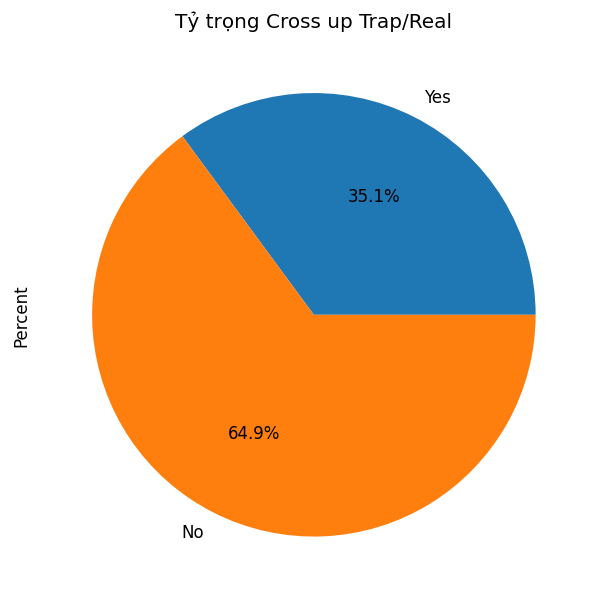

In [79]:
pd.DataFrame(pie_data).plot.pie(
    y="Percent",          
    labels=pie_data["Trap"],
    autopct="%1.1f%%",
    figsize=(6, 6),
    legend=False,
    title="Tỷ trọng Cross up Trap/Real"
)

### Cross down pull back

<Axes: title={'center': 'Cross down and pull back'}, xlabel='Date'>

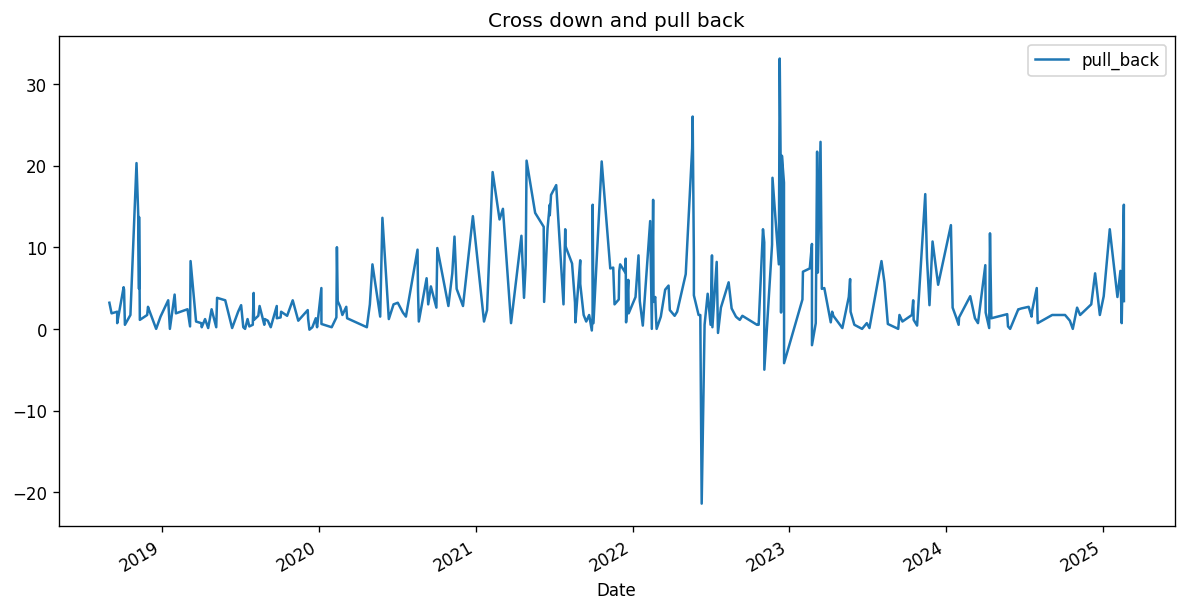

In [80]:
cross_down_data = data[(data.ema_cross==True) & (data.ema_fast < data.ema_low)]
cross_down_data["pull_back"] = cross_down_data["max_high_20bars_later"] - cross_down_data["Close"]
cross_down_data.plot(kind="line", y="pull_back",  title="Cross down and pull back")

<Axes: title={'center': 'Tỷ trọng Cross down Trap/Real'}, ylabel='Percent'>

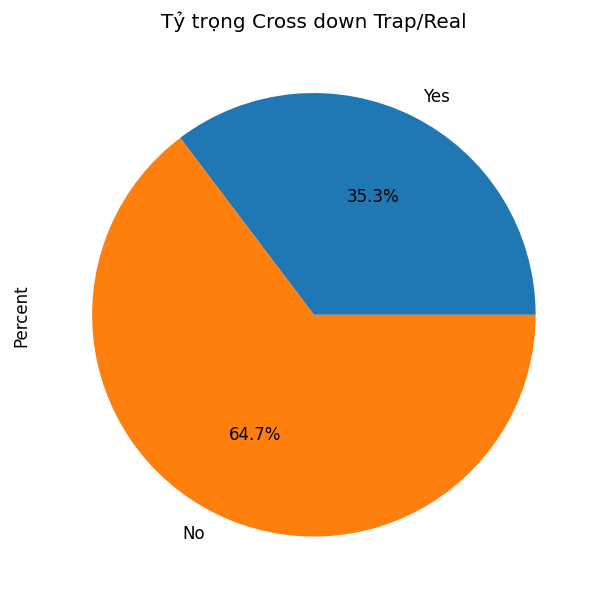

In [81]:
trap_percent = 100 * round(len(cross_down_data[cross_down_data.trap == 'yes']) / len(cross_down_data), 3)
pie_data = {
    "Trap": ["Yes", "No"],
    "Percent": [trap_percent, 100 - trap_percent]
}
pd.DataFrame(pie_data).plot.pie(
    y="Percent",          
    labels=pie_data["Trap"],
    autopct="%1.1f%%",
    figsize=(6, 6),
    legend=False,
    title="Tỷ trọng Cross down Trap/Real"
)